In [2]:
import os
import librosa
import soundfile as sf
import numpy as np
import pandas as pd
import seaborn as sns
import optuna
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.svm import SVC
import xgboost as xgb
import warnings
import hashlib
import soundfile as sf
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier

warnings.filterwarnings('ignore')

c:\Users\sassi\Documents\DeepFakePhishing\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# File preprocessing

In [19]:
base_path = "C:/Users/sassi/Documents/DeepFakePhishing/Data/for-norm/"

In [ ]:
# Check files that have 0 time duration
def count_zero_duration_files(dataset_path):
    zero_duration_count = 0
    total_files = 0
    empty_files = []

    for split in ['training', 'validation', 'test']:  # Adjust based on your dataset structure
        for folder in ['real', 'fake']:
            folder_path = os.path.join(dataset_path, split, folder)
            if not os.path.exists(folder_path):
                print(f"Warning: Folder {folder_path} does not exist.")
                continue

            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                
                try:
                    audio, sample_rate = librosa.load(file_path, sr=None)
                    total_files += 1
                    if len(audio) == 0:  # Check if audio is empty
                        zero_duration_count += 1
                        empty_files.append(file_path)
                
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")

    print(f"\nTotal files checked: {total_files}")
    print(f"Files with 0 duration: {zero_duration_count}")
    if zero_duration_count > 0:
        print("\nList of empty/corrupt files:")
        for f in empty_files:
            print(f)

In [4]:
count_zero_duration_files(base_path)

KeyboardInterrupt: 

# Feature extraction
Using librosa TO extract relevant features from the audio files. This is done because ML works with statistical information rather than directly with sound. We consider:
- **MFCCs**: Represents the **short-term power spectrum of a sound**, commonly used in speech and audio recognition.
    - These 13 coefficients represent the "shape" of the spectral envelope after apply a transformation. They capture the various timbral and spectral characteristics of the sound that correspond to different frequencies.
- **Chroma**: Captures the **energy distribution across the 12 pitch classes** (musical notes) and is useful for harmonic and tonal analysis.
    - If the harmonic content is important (ex. distinguish between real and shyntitized  voices based on timbre), keep all 12 values can be useful. If you want a global measure, you can reduce 12 to 1. If you're working with human voice, the notes variation could not be critical, sol reduce to only one value can be enough.
- **Spectral Contrast**: Measures the difference in amplitude between peaks and valleys in the frequency spectrum, indicating **timbre characteristics**.
    - Each value represents the intensity difference between more powerful and more weak parts of the spectrum in 7 different frequency bandwidth. If the objective is the analysis of speaking (deepfake vs real), the spectral contrast could be more useful with single band.
- **Spectral Centroid**: Represents the "center of mass" of the spectrum, often perceived as the **brightness of the sound**.
- **Spectral bandwidth**: Measures the spread of frequencies around the spectral centroid, related to **timbral richness**.
- **Spectral rolloff**: The frequency below which a certain percentage of the total spectral energy is contained, used for distinguishing voiced from unvoiced sounds.
- **Zero Crossing Rate**: The rate at which the audio signal crosses the zero amplitude axis, useful for detecting **percussive or noisy sounds**.
- **RMS (Root Mean Square Energy)**: Measures the **overall energy of the signal** over time.

In [20]:
# Load audio files and extract features
def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path, sr=None)

    if len(audio) == 0:
        print(f"Errore: il file {file_path} è vuoto o corrotto.", flush=True)
        return None


    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
    spec_contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate)
    spec_centroid = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)
    spec_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sample_rate)
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio)
    rms = librosa.feature.rms(y=audio)


    features = np.hstack([
        np.mean(mfccs, axis=1),
        np.mean(chroma, axis=1),
        np.mean(spec_contrast),
        np.mean(spec_centroid, axis=1),
        np.mean(spec_bandwidth, axis=1),
        np.mean(rolloff, axis=1),
        np.mean(zero_crossing_rate, axis=1),
        np.mean(rms, axis=1),
    ])
    
    return features

In [21]:
#Function to load data
def load_data(split):
    data = []
    labels = []

    print(f"Inizio caricamento dati per '{split}'...")

    for label, folder in enumerate(['real', 'fake']):  # 0 = real, 1 = fake
        folder_path = os.path.join(base_path, split, folder)
        
        # Controllo se la cartella esiste
        if not os.path.exists(folder_path):
            print(f"Attenzione: la cartella {folder_path} non esiste. Saltata.")
            continue

        print(f"Processando cartella: {folder_path} ({'REAL' if label == 0 else 'FAKE'})")

        file_list = os.listdir(folder_path)
        print(f"Trovati {len(file_list)} file in {folder_path}")

        for idx, file in enumerate(file_list):
            file_path = os.path.join(folder_path, file)

            # Controllo che il file sia audio
            if not file.lower().endswith(('.wav', '.mp3', '.flac')):
                print(f"Skipping non-audio file: {file}")
                continue

            features = extract_features(file_path)
            
            # Controllo se il file ha restituito feature valide
            if features is None:
                print(f"Errore nel file: {file_path}. Ignorato.")
                continue

            data.append(features)
            labels.append(label)

            # Stampa ogni 100 file elaborati
            if idx % 5000 == 0:
                print(f"{idx}/{len(file_list)} file elaborati...")

    print(f"Caricamento dati completato per '{split}'. Totale file validi: {len(data)}\n")

    return np.array(data), np.array(labels)

In [22]:
# Load training data
X_train, y_train = load_data('training')

Inizio caricamento dati per 'training'...
Processando cartella: C:/Users/sassi/Documents/DeepFakePhishing/Data/for-norm/training\real (REAL)
Trovati 26939 file in C:/Users/sassi/Documents/DeepFakePhishing/Data/for-norm/training\real
0/26939 file elaborati...
5000/26939 file elaborati...
10000/26939 file elaborati...
15000/26939 file elaborati...
20000/26939 file elaborati...
25000/26939 file elaborati...
Processando cartella: C:/Users/sassi/Documents/DeepFakePhishing/Data/for-norm/training\fake (FAKE)
Trovati 26927 file in C:/Users/sassi/Documents/DeepFakePhishing/Data/for-norm/training\fake
0/26927 file elaborati...
5000/26927 file elaborati...
10000/26927 file elaborati...
15000/26927 file elaborati...
20000/26927 file elaborati...
25000/26927 file elaborati...
Caricamento dati completato per 'training'. Totale file validi: 53866



In [25]:
# Load validation and testing data
X_val, y_val = load_data('validation')
X_test, y_test = load_data('testing')

Inizio caricamento dati per 'validation'...
Processando cartella: C:/Users/sassi/Documents/DeepFakePhishing/Data/for-norm/validation\real (REAL)
Trovati 5400 file in C:/Users/sassi/Documents/DeepFakePhishing/Data/for-norm/validation\real
0/5400 file elaborati...
5000/5400 file elaborati...
Processando cartella: C:/Users/sassi/Documents/DeepFakePhishing/Data/for-norm/validation\fake (FAKE)
Trovati 5398 file in C:/Users/sassi/Documents/DeepFakePhishing/Data/for-norm/validation\fake
0/5398 file elaborati...
5000/5398 file elaborati...
Caricamento dati completato per 'validation'. Totale file validi: 10798

Inizio caricamento dati per 'testing'...
Processando cartella: C:/Users/sassi/Documents/DeepFakePhishing/Data/for-norm/testing\real (REAL)
Trovati 2264 file in C:/Users/sassi/Documents/DeepFakePhishing/Data/for-norm/testing\real
0/2264 file elaborati...
Processando cartella: C:/Users/sassi/Documents/DeepFakePhishing/Data/for-norm/testing\fake (FAKE)
Trovati 2370 file in C:/Users/sassi/D

# Dataframe creation

(Use this if you want to extract fetures from audio or you don't have the xlsx files)

In [23]:
feature_names = []

# MFCC (40)
for i in range(40):
    feature_names.append(f'Mfcc{i+1}')

# Chroma (12)
for i in range(12):
    feature_names.append(f'Chroma{i+1}')

# Spectral Contrast (1)
feature_names.append('Spectral Contrast')

# Spectral Centroid (1)
feature_names.append('Spectral Centroid')

# Spectral Bandwidth (1)
feature_names.append('Spectral Bandwidth')

# Spectral Rolloff (1)
feature_names.append('Spectral Rolloff')

# Zero Crossing Rate (1)
feature_names.append('Zero Crossing Rate')

# RMS (1)
feature_names.append('RMS')

In [ ]:
# DataFrame creation for better visualization
df_train = pd.DataFrame(X_train, columns=feature_names)
df_train['Label'] = y_train 
print("Training Data Table:")
df_train.head()

Training Data Table:


,Mfcc1,Mfcc2,Mfcc3,Mfcc4,Mfcc5,Mfcc6,Mfcc7,Mfcc8,Mfcc9,Mfcc10,...,Chroma10,Chroma11,Chroma12,Spectral Contrast,Spectral Centroid,Spectral Bandwidth,Spectral Rolloff,Zero Crossing Rate,RMS,Label
0,-210.427582,83.100883,-13.509092,8.969434,-22.995165,-24.025053,-36.124195,-21.663410,9.863433,-23.533497,...,0.543745,0.372999,0.348506,22.587396,1822.402563,1500.086348,3311.115506,0.137460,0.126172,0
1,-163.614975,98.326889,1.710896,57.444717,-20.537626,27.244600,-30.749813,3.863749,-14.332317,5.208756,...,0.451867,0.368412,0.356717,19.067866,1768.520360,1465.244396,3338.242828,0.154065,0.133983,0
2,-222.616348,101.717888,41.213387,40.831959,1.462388,8.924045,-5.727610,4.540191,-3.396262,8.970129,...,0.565304,0.535076,0.431929,18.589779,1446.031905,1533.366622,2730.610795,0.095206,0.131446,0
3,-248.613052,83.622032,0.062521,2.170370,-35.400272,-19.093464,-21.039410,-25.623812,-7.879515,-16.343533,...,0.390245,0.398154,0.342880,21.765307,2033.304687,1511.028950,3504.194631,0.188090,0.083413,0
4,-191.011032,83.458107,-16.166752,0.279295,-23.390118,-19.999973,-33.995953,-33.259640,-4.133698,-11.123579,...,0.311889,0.268456,0.232835,22.276781,2081.626495,1411.119670,3395.873092,0.193106,0.129482,0


In [25]:
label_counts = df_train['Label'].value_counts()
print(label_counts)

Label
0    26939
1    26927
Name: count, dtype: int64


In [26]:
df_train.shape

(53866, 59)

In [27]:
df_train.to_excel("data_training.xlsx")

In [39]:
df_val = pd.DataFrame(X_val, columns=feature_names)
df_val['Label'] = y_val
print("Validation Data Table:")
df_val.head()

Validation Data Table:


,Mfcc1,Mfcc2,Mfcc3,Mfcc4,Mfcc5,Mfcc6,Mfcc7,Mfcc8,Mfcc9,Mfcc10,...,Chroma10,Chroma11,Chroma12,Spectral Contrast,Spectral Centroid,Spectral Bandwidth,Spectral Rolloff,Zero Crossing Rate,RMS,Label
0,-238.974258,72.536308,1.223852,15.655237,-29.314367,-19.493105,-25.080332,-16.982630,-1.724664,-20.331381,...,0.331176,0.375943,0.324426,21.935752,1965.892798,1703.828553,3761.795343,0.149725,0.085591,0
1,-256.018982,91.425346,-2.939981,-4.567071,-21.378895,-17.448601,-33.003525,-28.107645,-7.865174,-14.368134,...,0.401176,0.422495,0.334235,21.988528,1817.877642,1472.532682,3229.144022,0.171663,0.081037,0
2,-148.034546,85.491753,-1.865801,59.424885,5.243252,-3.699010,6.415993,-4.603085,0.528992,-2.462679,...,0.376732,0.422606,0.506260,16.519167,1673.699970,1559.891004,3197.492733,0.114190,0.143496,0
3,-156.547043,61.080147,-5.949994,27.725830,-22.817307,-20.771267,-20.866989,-29.392025,-8.442440,-6.201184,...,0.421435,0.309620,0.167528,22.883930,2212.853510,1671.732239,3949.678309,0.162736,0.143603,0
4,-182.339005,96.803482,1.770732,16.723940,-4.592342,-7.951765,-27.180761,-13.446073,-20.708775,-3.593056,...,0.353901,0.395303,0.337183,20.880772,1526.208947,1554.990750,2920.332404,0.104956,0.126455,0


In [89]:
label_counts = df_val['Label'].value_counts()
print(label_counts)

Label
0    5400
1    5398
Name: count, dtype: int64


In [92]:
df_val.shape

(10798, 59)

In [40]:
df_test = pd.DataFrame(X_test, columns=feature_names)
df_test['Label'] = y_test
print("Testing Data Table:")
df_test.head()

Testing Data Table:


,Mfcc1,Mfcc2,Mfcc3,Mfcc4,Mfcc5,Mfcc6,Mfcc7,Mfcc8,Mfcc9,Mfcc10,...,Chroma10,Chroma11,Chroma12,Spectral Contrast,Spectral Centroid,Spectral Bandwidth,Spectral Rolloff,Zero Crossing Rate,RMS,Label
0,-181.517868,118.166695,-6.149240,2.363741,-23.292242,8.662042,-17.975237,3.649966,-9.678282,4.280863,...,0.129655,0.108808,0.135015,23.103355,1263.625222,1293.462320,2181.189904,0.095096,0.204761,0
1,-158.852890,95.698990,-0.826252,33.087421,-20.912750,-7.544246,-16.037512,-2.116656,-10.096004,0.448813,...,0.196711,0.188460,0.207523,22.419221,1426.331405,1500.241027,2836.755087,0.097594,0.181770,0
2,-156.366852,126.240074,-1.076348,39.485641,-51.288452,-6.996190,0.359351,-31.043701,-16.523739,0.276970,...,0.450284,0.241702,0.128277,23.065209,1177.898651,1290.098302,2507.291667,0.061263,0.172729,0
3,-147.409348,79.132111,0.541090,35.914303,-22.020681,1.379500,-17.997663,-33.442825,-12.930269,-4.153602,...,0.336975,0.320168,0.362635,22.271015,1830.254791,1630.497247,3584.325397,0.114010,0.144346,0
4,-199.839920,77.098900,-6.385015,28.290428,-17.723967,-3.694778,-22.055264,5.760507,-7.685007,2.497854,...,0.339412,0.195335,0.171155,21.251352,1960.886772,1617.046998,3577.533144,0.173369,0.121868,0


In [90]:
label_counts = df_test['Label'].value_counts()
print(label_counts)

Label
1    2370
0    2264
Name: count, dtype: int64


In [93]:
df_test.shape

(4634, 59)

# Data Load from Excel
Use this instead of extract features every time

## Training Dataset

In [3]:
df_train = pd.read_excel("C:/Users/sassi/Documents/DeepFakePhishing/Data/for-norm/data_training.xlsx")
df_train = df_train.loc[:, ~df_train.columns.str.contains("^Unnamed")]

df_train.head()

,Mfcc1,Mfcc2,Mfcc3,Mfcc4,Mfcc5,Mfcc6,Mfcc7,Mfcc8,Mfcc9,Mfcc10,...,Chroma10,Chroma11,Chroma12,Spectral Contrast,Spectral Centroid,Spectral Bandwidth,Spectral Rolloff,Zero Crossing Rate,RMS,Label
0,-210.427582,83.100883,-13.509092,8.969434,-22.995165,-24.025053,-36.124195,-21.663410,9.863433,-23.533497,...,0.543745,0.372999,0.348506,22.587396,1822.402563,1500.086348,3311.115506,0.137460,0.126172,0
1,-163.614975,98.326889,1.710896,57.444717,-20.537626,27.244600,-30.749813,3.863749,-14.332317,5.208756,...,0.451867,0.368412,0.356717,19.067866,1768.520360,1465.244396,3338.242828,0.154065,0.133983,0
2,-222.616348,101.717888,41.213387,40.831959,1.462388,8.924045,-5.727610,4.540191,-3.396262,8.970129,...,0.565304,0.535076,0.431929,18.589779,1446.031905,1533.366622,2730.610795,0.095206,0.131446,0
3,-248.613052,83.622032,0.062521,2.170370,-35.400272,-19.093464,-21.039410,-25.623812,-7.879515,-16.343533,...,0.390245,0.398154,0.342880,21.765307,2033.304687,1511.028950,3504.194631,0.188090,0.083413,0
4,-191.011032,83.458107,-16.166752,0.279295,-23.390118,-19.999973,-33.995953,-33.259640,-4.133698,-11.123579,...,0.311889,0.268456,0.232835,22.276781,2081.626495,1411.119670,3395.873092,0.193106,0.129482,0


In [4]:
# Split dataset into features and label
X_train = df_train.drop(columns=["Label"]).values #NumPy array
y_train = df_train["Label"].values  

# Print shapes to verify
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (53866, 58)
y_train shape: (53866,)


## Validation Dataset

In [5]:
df_val = pd.read_excel("C:/Users/sassi/Documents/DeepFakePhishing/Data/for-norm/data_validation.xlsx")
df_val = df_val.loc[:, ~df_val.columns.str.contains("^Unnamed")]

df_val.head()

,Mfcc1,Mfcc2,Mfcc3,Mfcc4,Mfcc5,Mfcc6,Mfcc7,Mfcc8,Mfcc9,Mfcc10,...,Chroma10,Chroma11,Chroma12,Spectral Contrast,Spectral Centroid,Spectral Bandwidth,Spectral Rolloff,Zero Crossing Rate,RMS,Label
0,-238.974258,72.536308,1.223852,15.655237,-29.314367,-19.493105,-25.080332,-16.982630,-1.724664,-20.331381,...,0.331176,0.375943,0.324426,21.935752,1965.892798,1703.828553,3761.795343,0.149725,0.085591,0
1,-256.018982,91.425346,-2.939981,-4.567071,-21.378895,-17.448601,-33.003525,-28.107645,-7.865174,-14.368134,...,0.401176,0.422495,0.334235,21.988528,1817.877642,1472.532682,3229.144022,0.171663,0.081037,0
2,-148.034546,85.491753,-1.865801,59.424885,5.243252,-3.699010,6.415993,-4.603085,0.528992,-2.462679,...,0.376732,0.422606,0.506260,16.519167,1673.699970,1559.891004,3197.492733,0.114190,0.143496,0
3,-156.547043,61.080147,-5.949994,27.725830,-22.817307,-20.771267,-20.866989,-29.392025,-8.442440,-6.201184,...,0.421435,0.309620,0.167528,22.883930,2212.853510,1671.732239,3949.678309,0.162736,0.143603,0
4,-182.339005,96.803482,1.770732,16.723940,-4.592342,-7.951765,-27.180761,-13.446073,-20.708775,-3.593056,...,0.353901,0.395303,0.337183,20.880772,1526.208947,1554.990750,2920.332404,0.104956,0.126455,0


In [6]:
# Split dataset into features and label
X_val = df_val.drop(columns=["Label"]).values #NumPy array
y_val = df_val["Label"].values 

# Print shapes to verify
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_val shape: (10798, 58)
y_val shape: (10798,)


## Test Dataset

In [7]:
df_test = pd.read_excel("C:/Users/sassi/Documents/DeepFakePhishing/Data/for-norm/data_test.xlsx")
df_test = df_test.loc[:, ~df_test.columns.str.contains("^Unnamed")]

df_test.head()

,Mfcc1,Mfcc2,Mfcc3,Mfcc4,Mfcc5,Mfcc6,Mfcc7,Mfcc8,Mfcc9,Mfcc10,...,Chroma10,Chroma11,Chroma12,Spectral Contrast,Spectral Centroid,Spectral Bandwidth,Spectral Rolloff,Zero Crossing Rate,RMS,Label
0,-181.517868,118.166695,-6.149240,2.363741,-23.292242,8.662042,-17.975237,3.649966,-9.678282,4.280863,...,0.129655,0.108808,0.135015,23.103355,1263.625222,1293.462320,2181.189904,0.095096,0.204761,0
1,-158.852890,95.698990,-0.826252,33.087421,-20.912750,-7.544246,-16.037512,-2.116656,-10.096004,0.448813,...,0.196711,0.188460,0.207523,22.419221,1426.331405,1500.241027,2836.755087,0.097594,0.181770,0
2,-156.366852,126.240074,-1.076348,39.485641,-51.288452,-6.996190,0.359351,-31.043701,-16.523739,0.276970,...,0.450284,0.241702,0.128277,23.065209,1177.898651,1290.098302,2507.291667,0.061263,0.172729,0
3,-147.409348,79.132111,0.541090,35.914303,-22.020681,1.379500,-17.997663,-33.442825,-12.930269,-4.153602,...,0.336975,0.320168,0.362635,22.271015,1830.254791,1630.497247,3584.325397,0.114010,0.144346,0
4,-199.839920,77.098900,-6.385015,28.290428,-17.723967,-3.694778,-22.055264,5.760507,-7.685007,2.497854,...,0.339412,0.195335,0.171155,21.251352,1960.886772,1617.046998,3577.533144,0.173369,0.121868,0


In [8]:
# Split dataset into features and label
X_test = df_test.drop(columns=["Label"]).values #NumPy array
y_test = df_test["Label"].values 

# Print shapes to verify
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_test shape: (4634, 58)
y_test shape: (4634,)


# Descriptive statistics

In [46]:
df_statistics = df_train.groupby('Label').agg(['mean', 'median', 'std'])
print("Training Data Statistics:")
df_statistics

Training Data Statistics:


Mfcc1                              Mfcc2                        \
             mean      median        std        mean     median        std   
Label                                                                        
0     -197.591602 -198.718689  43.036267   86.786750  83.144936  25.516144   
1     -173.024757 -168.867584  47.018799  102.719159  99.015984  33.013852   

          Mfcc3                           Mfcc4  ... Spectral Bandwidth  \
           mean    median        std       mean  ...                std   
Label                                            ...                      
0     -1.271298  0.714253  19.833538  24.198164  ...         188.113648   
1     -9.239074 -7.769844  19.573006  31.183492  ...         233.563674   

      Spectral Rolloff                          Zero Crossing Rate            \
                  mean       median         std               mean    median   
Label                                                                          
0          3307.093119  3408.605239  743.160626           0.145170  0.148495   
1          2923.688671  2933.262712  695.591360           0.132923  0.126742   

                      RMS                      
            std      mean    median       std  
Label                                          
0      0.059683  0.123724  0.113689  0.053239  
1      0.046474  0.165344  0.161870  0.039027  

[2 rows x 174 columns]

## T-test

In [ ]:
# Separate the data based on label 
real_data = df_train[df_train['Label'] == 0].drop(columns='Label')
fake_data = df_train[df_train['Label'] == 1].drop(columns='Label')

# Initialize a dictionary to store the results
t_test_results = {}

# Perform t-test for each feature
for feature in real_data.columns:
    # Extract values for the current feature from both real and fake data
    real_values = real_data[feature]
    fake_values = fake_data[feature]
    
    # Perform an independent t-test
    t_stat, p_value = stats.ttest_ind(real_values, fake_values)
    
    # Store the results
    t_test_results[feature] = {'t_stat': t_stat, 'p_value': p_value, 'Significant?': 'Yes' if p_value < 0.05 else 'No'}

# Convert results into a DataFrame for better visualization
t_test_df = pd.DataFrame.from_dict(t_test_results, orient='index')

# Display the results
print("T-test Results:")
t_test_df

## Correlation Matrix

In [51]:
correlation_matrix = df_train.corr()
feature_label_corr = correlation_matrix['Label'].drop('Label')  # Drop 'Label' from its own correlation
print("Correlation between features and label:")
print(feature_label_corr)

Correlation between features and label:
Mfcc1                 0.262949
Mfcc2                 0.260680
Mfcc3                -0.198183
Mfcc4                 0.188001
Mfcc5                 0.062787
Mfcc6                 0.173215
Mfcc7                 0.141931
Mfcc8                -0.048081
Mfcc9                -0.237623
Mfcc10               -0.080714
Mfcc11               -0.140104
Mfcc12                0.032047
Mfcc13               -0.344809
Mfcc14                0.192560
Mfcc15               -0.223549
Mfcc16                0.093520
Mfcc17               -0.278872
Mfcc18                0.032343
Mfcc19               -0.266363
Mfcc20               -0.031643
Mfcc21               -0.087122
Mfcc22                0.166159
Mfcc23               -0.126622
Mfcc24                0.214368
Mfcc25               -0.119135
Mfcc26                0.252378
Mfcc27               -0.035605
Mfcc28                0.159076
Mfcc29                0.071977
Mfcc30                0.132653
Mfcc31                0.076836

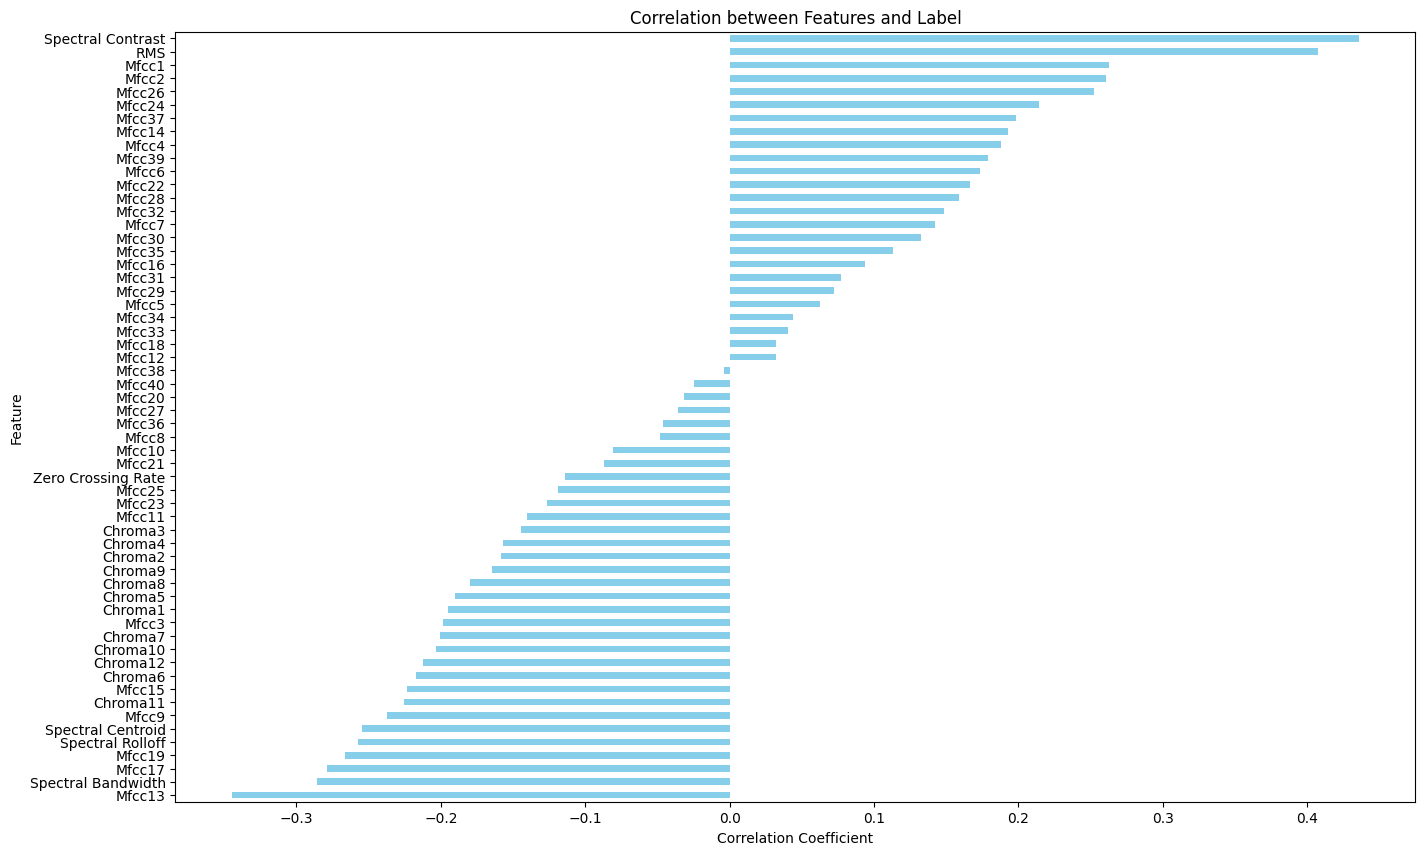

In [56]:
correlation_values = {
    'Mfcc1': 0.262949,
    'Mfcc2': 0.260680,
    'Mfcc3': -0.198183,
    'Mfcc4': 0.188001,
    'Mfcc5': 0.062787,
    'Mfcc6': 0.173215,
    'Mfcc7': 0.141931,
    'Mfcc8': -0.048081,
    'Mfcc9': -0.237623,
    'Mfcc10':  -0.080714,
    'Mfcc11':  -0.140104,
    'Mfcc12': 0.032047,
    'Mfcc13': -0.344809,
    'Mfcc14': 0.192560,
    'Mfcc15': -0.223549,
    'Mfcc16': 0.093520,
    'Mfcc17': -0.278872,
    'Mfcc18': 0.032343,
    'Mfcc19': -0.266363,
    'Mfcc20': -0.031643,
    'Mfcc21': -0.087122,
    'Mfcc22': 0.166159,
    'Mfcc23': -0.126622,
    'Mfcc24': 0.214368,
    'Mfcc25': -0.119135,
    'Mfcc26': 0.252378,
    'Mfcc27': -0.035605,
    'Mfcc28': 0.159076,
    'Mfcc29': 0.071977,
    'Mfcc30': 0.132653,
    'Mfcc31': 0.076836,
    'Mfcc32': 0.148640,
    'Mfcc33': 0.040641,
    'Mfcc34': 0.043757,
    'Mfcc35': 0.113213,
    'Mfcc36': -0.046384,
    'Mfcc37': 0.198667,
    'Mfcc38': -0.003576,
    'Mfcc39': 0.178758,
    'Mfcc40': -0.024689,
    'Chroma1':  -0.195048,
    'Chroma2':  -0.158153,
    'Chroma3':  -0.144554,
    'Chroma4':  -0.157049,
    'Chroma5':  -0.190279,
    'Chroma6':  -0.217101,
    'Chroma7':  -0.200246,
    'Chroma8':  -0.180150,
    'Chroma9':  -0.164567,
    'Chroma10':  -0.203439,
    'Chroma11':  -0.225368,
    'Chroma12':  -0.212104,
    'Spectral Contrast': 0.435917,
    'Spectral Centroid': -0.254938,
    'Spectral Bandwidth': -0.286005,
    'Spectral Rolloff': -0.257369,
    'Zero Crossing Rate': -0.113744,
    'RMS': 0.407185
}

correlation_df = pd.Series(correlation_values)

# Plotting the correlations between features and label
plt.figure(figsize=(16, 10))
correlation_df.sort_values().plot(kind='barh', color='skyblue')
plt.title('Correlation between Features and Label')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.show()

# Data preprocessing

## Feature scaling

In [9]:
# Normalize features
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Models Training

## Support Vector Machine

In [ ]:
# Hyperparameter tuning

def objective(trial):
    # Hyperparameters to tune
    C = trial.suggest_loguniform('C', 1e-3, 1e2)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid']) 
    degree = trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3 
    gamma = trial.suggest_loguniform('gamma', 1e-4, 1e1) if kernel in ['rbf', 'poly', 'sigmoid'] else 'scale'  
    coef0 = trial.suggest_uniform('coef0', 0.0, 1.0) if kernel in ['poly', 'sigmoid'] else 0.0 
    
    # SVM classifier with the suggested hyperparameters
    svc = SVC(
        C=C,
        kernel=kernel,
        degree=degree,
        gamma=gamma,
        coef0=coef0,
        random_state=42
    )
    
    svc.fit(X_train_scaled, y_train)
    y_val_pred = svc.predict(X_val_scaled)

    score = f1_score(y_val, y_val_pred)
    return score


# Create an Optuna study
study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective, n_trials=50)  

[I 2025-04-01 12:06:19,752] A new study created in memory with name: no-name-6031b987-454f-4667-9f96-19081fefffda
[I 2025-04-01 12:07:06,254] Trial 0 finished with value: 0.9102540330057481 and parameters: {'C': 0.0011110763490679253, 'kernel': 'linear'}. Best is trial 0 with value: 0.9102540330057481.
[I 2025-04-01 12:09:05,242] Trial 1 finished with value: 0.9169627828688984 and parameters: {'C': 0.2483366145301617, 'kernel': 'linear'}. Best is trial 1 with value: 0.9169627828688984.
[I 2025-04-01 12:09:47,583] Trial 2 finished with value: 0.9160119715675271 and parameters: {'C': 0.007458716360001537, 'kernel': 'linear'}. Best is trial 1 with value: 0.9169627828688984.
[W 2025-04-01 12:11:55,362] Trial 3 failed with parameters: {'C': 0.0037457672817105586, 'kernel': 'rbf', 'gamma': 0.001682359381757144} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\sassi\Documents\DeepFakePhishing\.venv\lib\site-packages\optuna\study\_optimiz

KeyboardInterrupt: 

In [11]:
print(f"Best Parameters: {study_svm.best_params}")
print(f"Best F1-score on validation set: {study_svm.best_value:.4f}")

Best Parameters: {'C': 0.2483366145301617, 'kernel': 'linear'}
Best F1-score on validation set: 0.9170



Support Vector Machine Results:
Accuracy: 0.9178
F1 Score: 0.9170
ROC AUC Score: 0.9178
Confusion Matrix:
[[5007  393]
 [ 495 4903]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      5400
           1       0.93      0.91      0.92      5398

    accuracy                           0.92     10798
   macro avg       0.92      0.92      0.92     10798
weighted avg       0.92      0.92      0.92     10798



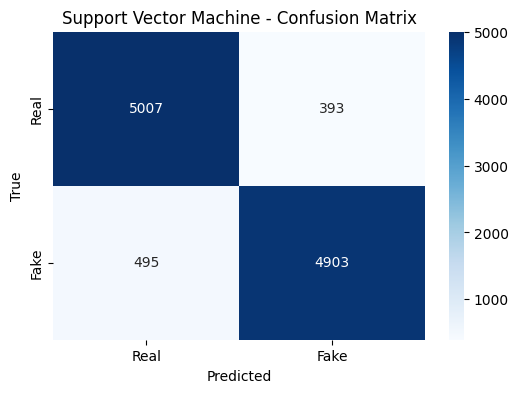

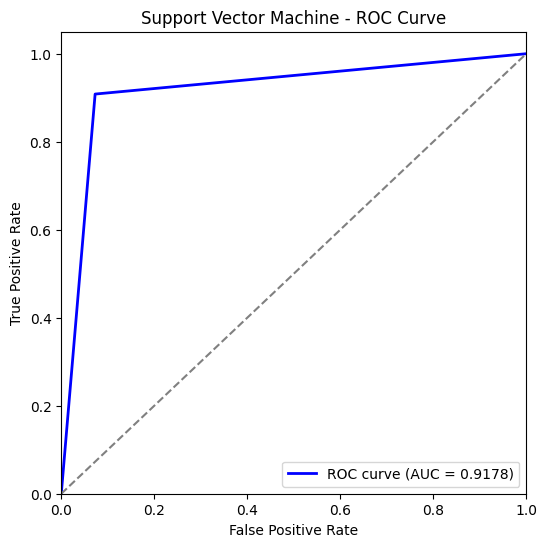

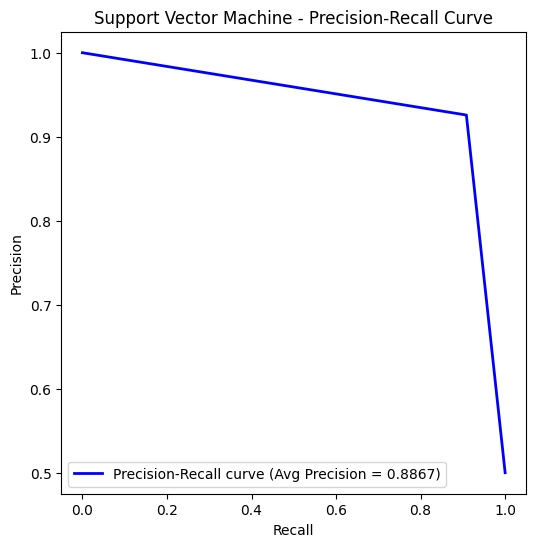

In [15]:
# Train the best SVM
best_svm_model = SVC(**study_svm.best_params)
best_svm_model.fit(X_train_scaled, y_train)

# Evaluate the SVM model on validation set
y_pred_svm = best_svm_model.predict(X_val_scaled)

evaluate_model(y_val, y_pred_svm , "Support Vector Machine")


Support Vector Machine Results:
Accuracy: 0.7743
F1 Score: 0.7699
ROC AUC Score: 0.7751
Confusion Matrix:
[[1838  426]
 [ 620 1750]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78      2264
           1       0.80      0.74      0.77      2370

    accuracy                           0.77      4634
   macro avg       0.78      0.78      0.77      4634
weighted avg       0.78      0.77      0.77      4634



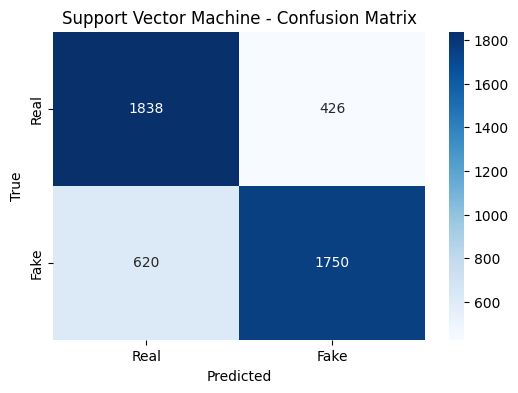

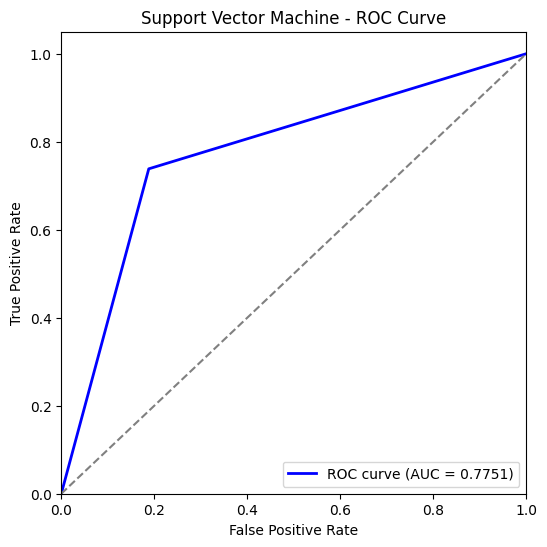

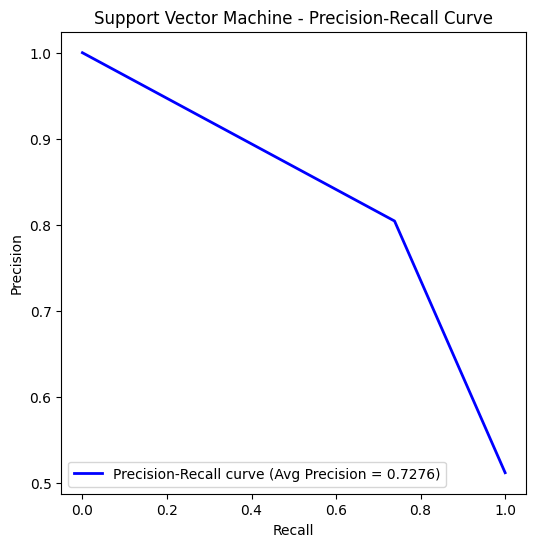

In [16]:
# Evaluate the SVM model on test set
y_test_pred = best_svm_model.predict(X_test_scaled)

evaluate_model(y_test, y_test_pred, "Support Vector Machine")

## Random Forest

In [73]:
# Hyperparameter Tuning using optuna

# Optuna objective function
def objective(trial):
    # Define hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 100, 400, step=50)
    max_depth = trial.suggest_categorical('max_depth', [None, 10, 20, 30, 40]) 
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10, step=1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    
    # Train Random Forest model
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    
    clf.fit(X_train_scaled, y_train)
    y_val_pred = clf.predict(X_val_scaled)

    score = f1_score(y_val, y_val_pred)
    return score

# Run Optuna optimization
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective, n_trials=50)

[I 2025-04-01 11:04:31,494] A new study created in memory with name: no-name-2a12e910-59b8-4df4-b9f8-95c8b3c1c558
[I 2025-04-01 11:04:36,014] Trial 0 finished with value: 0.9805158656522546 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.9805158656522546.
[I 2025-04-01 11:04:48,537] Trial 1 finished with value: 0.9908256880733946 and parameters: {'n_estimators': 400, 'max_depth': 40, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.9908256880733946.
[I 2025-04-01 11:08:37,861] Trial 2 finished with value: 0.9850027772634697 and parameters: {'n_estimators': 350, 'max_depth': None, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 1 with value: 0.9908256880733946.
[I 2025-04-01 11:08:51,666] Trial 3 finished with value: 0.9916573971078977 and parameters: {'n_estimators': 300, 'max_depth': None, 

In [74]:
# Display Best Hyperparameters and Best Cross-validation Score
print(f"Best Parameters for Random Forest: {study_rf.best_params}")
print(f"Best F1-Score on validation set: {study_rf.best_value:.4f}")

Best Parameters for Random Forest: {'n_estimators': 350, 'max_depth': 40, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best F1-Score on validation set: 0.9933



Random Forest Results:
Accuracy: 0.9933
F1 Score: 0.9933
ROC AUC Score: 0.9933
Confusion Matrix:
[[5366   34]
 [  38 5360]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5400
           1       0.99      0.99      0.99      5398

    accuracy                           0.99     10798
   macro avg       0.99      0.99      0.99     10798
weighted avg       0.99      0.99      0.99     10798



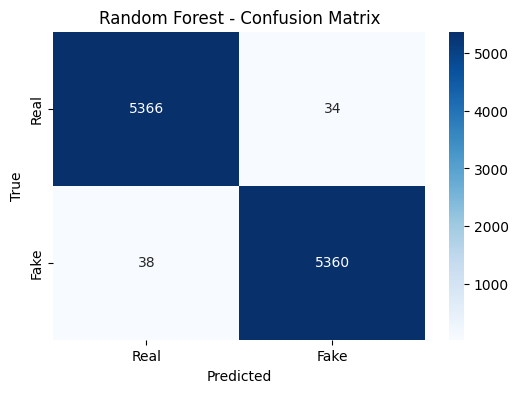

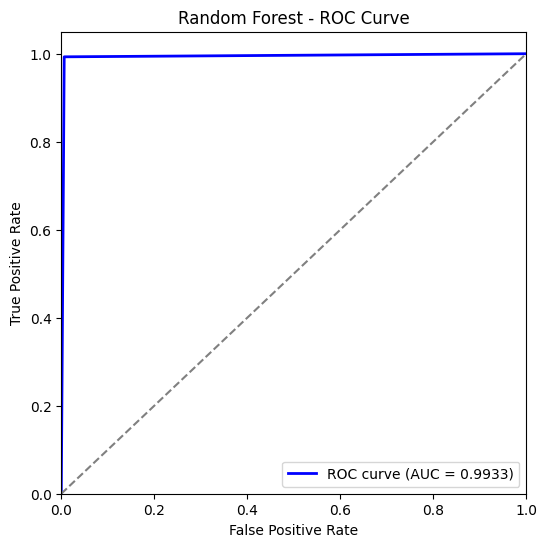

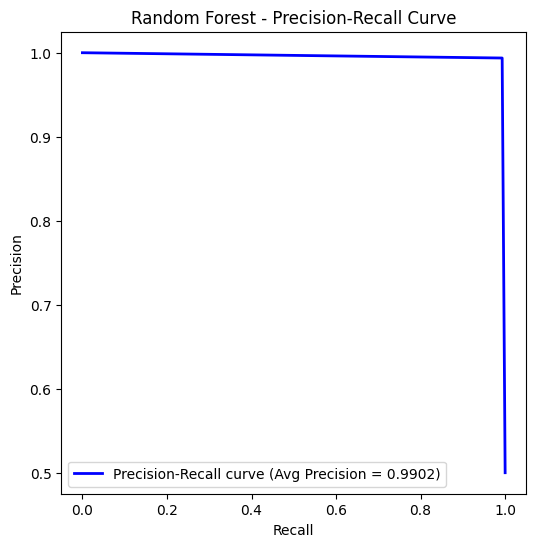

In [76]:
# Train the best Random Forest Classifier
best_rf_model = RandomForestClassifier(**study_rf.best_params, random_state=42)
best_rf_model.fit(X_train_scaled, y_train)

# Evaluate the Random Forest model on validation set
y_pred_rf = best_rf_model.predict(X_val_scaled)

evaluate_model(y_val, y_pred_rf , "Random Forest")


Random Forest Results:
Accuracy: 0.8874
F1 Score: 0.8801
ROC AUC Score: 0.8892
Confusion Matrix:
[[2196   68]
 [ 454 1916]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      2264
           1       0.97      0.81      0.88      2370

    accuracy                           0.89      4634
   macro avg       0.90      0.89      0.89      4634
weighted avg       0.90      0.89      0.89      4634



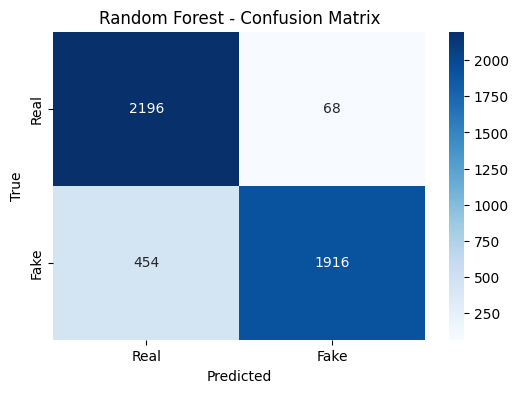

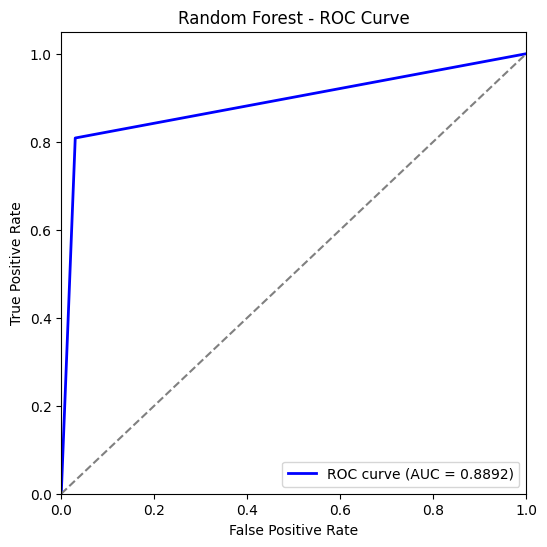

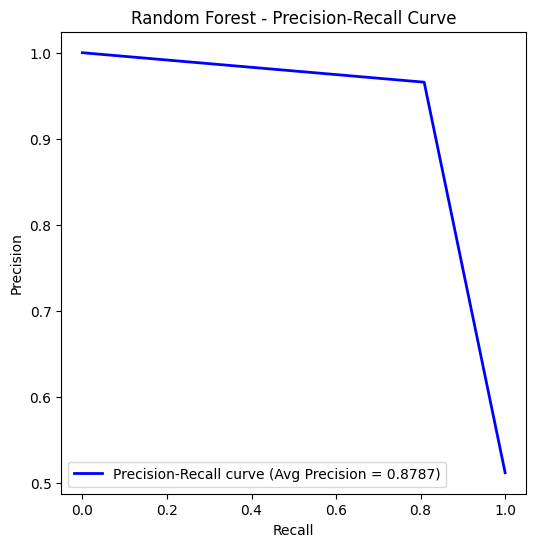

In [ ]:
# Evaluate the Random Forest model on test set
y_test_pred = best_rf_model.predict(X_test_scaled)

evaluate_model(y_test, y_test_pred, "Random Forest")

In [ ]:
# See the features importnat based on Gini Impurity Index
feature_importances = best_rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Important Features')
plt.show()

## XGBoost

In [67]:
# Hyperparamter tuning

def objective(trial):
    param = {
        'objective': 'binary:logistic', 
        'eval_metric': 'logloss',        
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),  
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'use_label_encoder': False,
        'n_jobs': -1,
        'random_state': 42
    }
    
    model = xgb.XGBClassifier(**param)
    model.fit(X_train_scaled, y_train)

    y_val_pred = model.predict(X_val_scaled)

    score = f1_score(y_val, y_val_pred)
    
    return score

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective, n_trials=50)

[I 2025-04-01 10:18:50,265] A new study created in memory with name: no-name-1796c52d-305e-4459-8307-3ad86bd58eb7
[I 2025-04-01 10:18:54,297] Trial 0 finished with value: 0.9935125115848007 and parameters: {'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.02637061558721509, 'subsample': 0.7549416400805354, 'colsample_bytree': 0.8460567990797201, 'gamma': 3.149529852677375, 'min_child_weight': 5, 'reg_alpha': 0.9739942427288769, 'reg_lambda': 0.389476176731967}. Best is trial 0 with value: 0.9935125115848007.
[I 2025-04-01 10:18:55,809] Trial 1 finished with value: 0.9932313398238294 and parameters: {'n_estimators': 450, 'max_depth': 9, 'learning_rate': 0.28689627333701223, 'subsample': 0.9448366202283226, 'colsample_bytree': 0.7449345695269216, 'gamma': 3.522976731444849, 'min_child_weight': 8, 'reg_alpha': 0.8448416648970487, 'reg_lambda': 0.4340187450657824}. Best is trial 0 with value: 0.9935125115848007.
[I 2025-04-01 10:18:56,993] Trial 2 finished with value: 0.98934494579

In [68]:
print(f"Best Parameters: {study_xgb.best_params}")
print(f"Best F1-Score on validation set: {study_xgb.best_value:.4f}")

Best Parameters: {'n_estimators': 800, 'max_depth': 5, 'learning_rate': 0.13106327010435492, 'subsample': 0.7282860839998613, 'colsample_bytree': 0.8379371648689776, 'gamma': 0.10901601529252575, 'min_child_weight': 2, 'reg_alpha': 0.35532728648190315, 'reg_lambda': 0.11939544673153567}
Best F1-Score on validation set: 0.9977



XGBoost Results:
Accuracy: 0.9977
F1 Score: 0.9977
ROC AUC Score: 0.9977
Confusion Matrix:
[[5391    9]
 [  16 5382]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5400
           1       1.00      1.00      1.00      5398

    accuracy                           1.00     10798
   macro avg       1.00      1.00      1.00     10798
weighted avg       1.00      1.00      1.00     10798



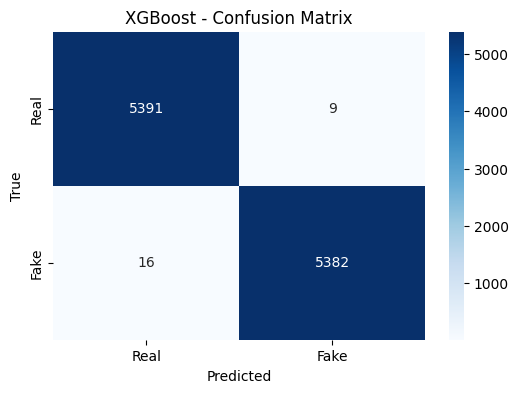

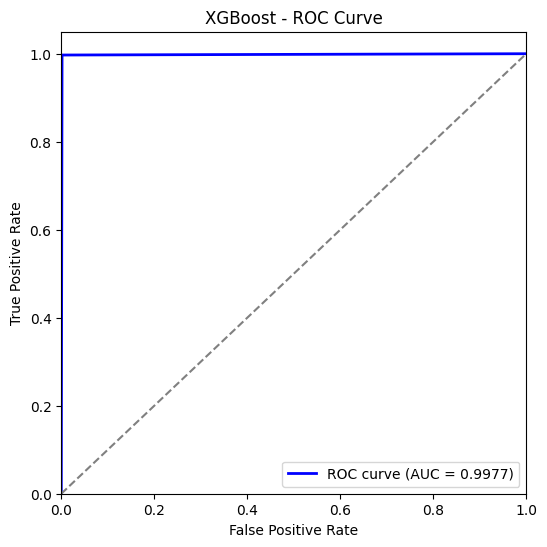

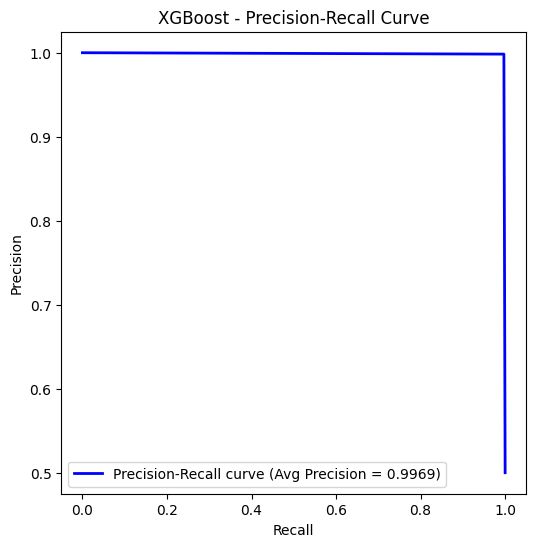

In [70]:
# Train the best XGBoost Classifier
best_xgb_model = xgb.XGBClassifier(**study_xgb.best_params, random_state=42)
best_xgb_model.fit(X_train_scaled, y_train)

# Evaluate the XGBoost model on validation set
y_pred_xgb = best_xgb_model.predict(X_val_scaled)

evaluate_model(y_val, y_pred_xgb , "XGBoost")


XGBoost Results:
Accuracy: 0.7982
F1 Score: 0.7559
ROC AUC Score: 0.8026
Confusion Matrix:
[[2251   13]
 [ 922 1448]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.99      0.83      2264
           1       0.99      0.61      0.76      2370

    accuracy                           0.80      4634
   macro avg       0.85      0.80      0.79      4634
weighted avg       0.85      0.80      0.79      4634



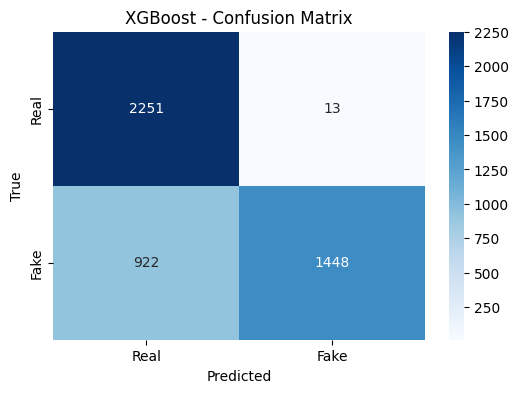

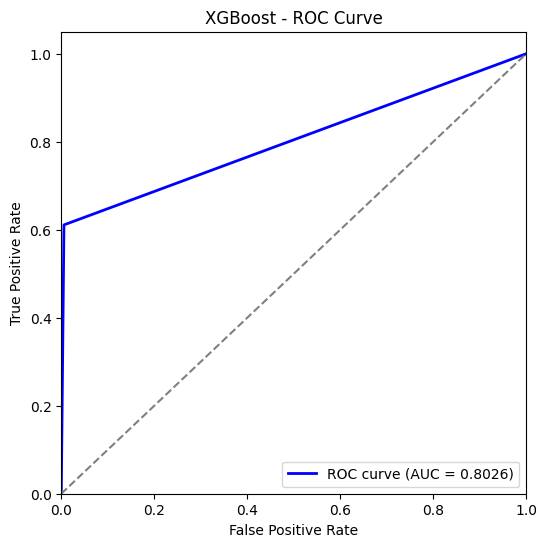

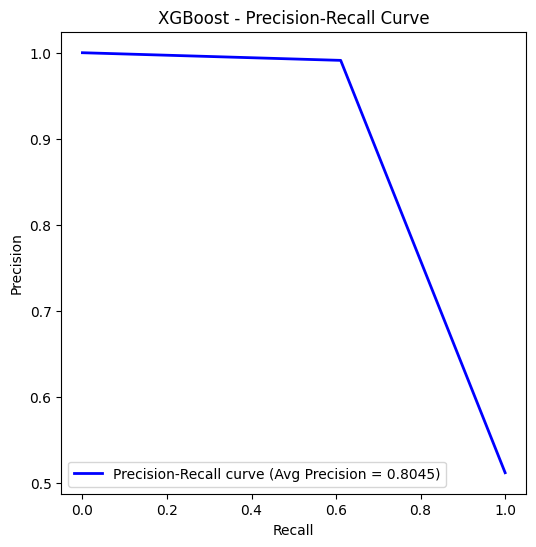

In [72]:
# Evaluate the XGBoost model on test set
y_test_pred = best_xgb_model.predict(X_test_scaled)

evaluate_model(y_test, y_test_pred, "XGBoost")

## KNN

In [60]:
# Hyperparameter tuning

def objective(trial):
    # Hyperparameters to tune
    n_neighbors = trial.suggest_int('n_neighbors', 3, 50) 
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])  
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])  
    p = trial.suggest_int('p', 1, 2) 
    leaf_size = trial.suggest_int('leaf_size', 10, 60)
    
    # KNN classifier with the suggested hyperparameters
    knn = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        algorithm=algorithm,
        p=p,
        leaf_size=leaf_size
    )
    
    knn.fit(X_train_scaled, y_train)

    y_val_pred = knn.predict(X_val_scaled)

    score = f1_score(y_val, y_val_pred)
    
    return score 

# Create an Optuna study
study_knn = optuna.create_study(direction='maximize')
study_knn.optimize(objective, n_trials=50) 

[I 2025-04-01 09:59:19,966] A new study created in memory with name: no-name-e62718a5-ffab-4542-88dd-f72204e16e7b
[I 2025-04-01 10:00:44,408] Trial 0 finished with value: 0.9880831408775982 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'algorithm': 'ball_tree', 'p': 1, 'leaf_size': 26}. Best is trial 0 with value: 0.9880831408775982.
[I 2025-04-01 10:01:57,650] Trial 1 finished with value: 0.9926939794691575 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'ball_tree', 'p': 1, 'leaf_size': 33}. Best is trial 1 with value: 0.9926939794691575.
[I 2025-04-01 10:03:56,662] Trial 2 finished with value: 0.9889155736190652 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'algorithm': 'kd_tree', 'p': 1, 'leaf_size': 11}. Best is trial 1 with value: 0.9926939794691575.
[I 2025-04-01 10:03:58,830] Trial 3 finished with value: 0.9932451189044138 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'brute', 'p': 1, 'leaf_size': 58}. Bes

KeyboardInterrupt: 

In [ ]:
print(f"Best Parameters: {study_knn.best_params}")
print(f"Best F1-Score on validation set: {study_knn.best_value:.4f}")

Best Parameters: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'brute', 'p': 2, 'leaf_size': 45}
Best Cross-Validation Score: 0.9946



KNN Results:
Accuracy: 0.9946
F1 Score: 0.9946
ROC AUC Score: 0.9946
Confusion Matrix:
[[5364   36]
 [  22 5376]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5400
           1       0.99      1.00      0.99      5398

    accuracy                           0.99     10798
   macro avg       0.99      0.99      0.99     10798
weighted avg       0.99      0.99      0.99     10798



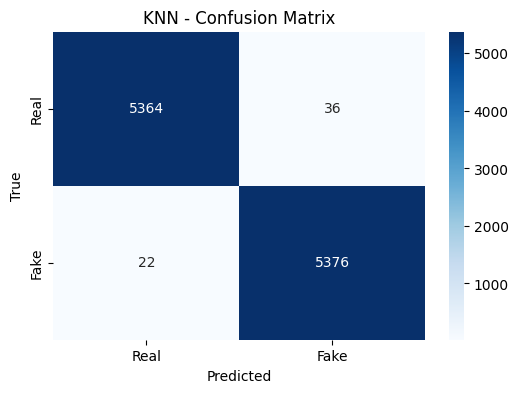

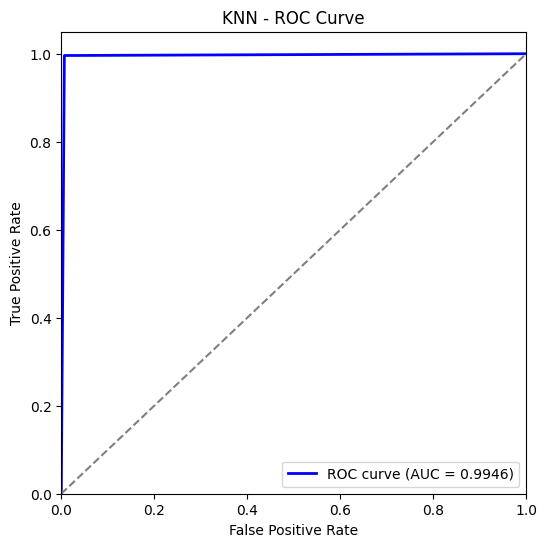

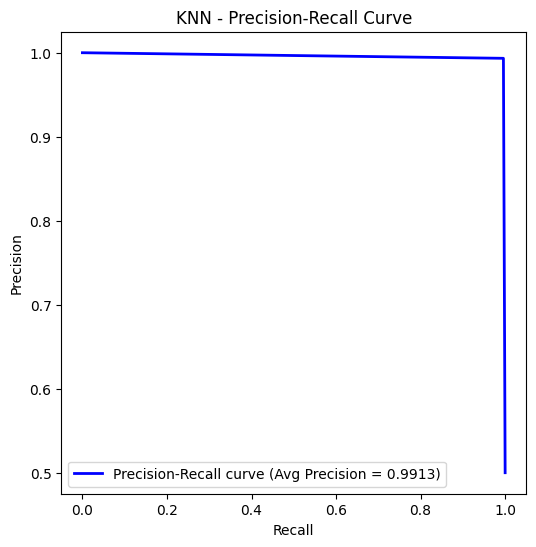

In [65]:
# Train the best KNN Classifier
best_knn_model = KNeighborsClassifier(**study_knn.best_params)
best_knn_model.fit(X_train_scaled, y_train)

# Evaluate the KNN model on validation set
y_pred_knn = best_knn_model.predict(X_val_scaled)

evaluate_model(y_val, y_pred_knn, "KNN")



KNN Results:
Accuracy: 0.8727
F1 Score: 0.8584
ROC AUC Score: 0.8754
Confusion Matrix:
[[2255    9]
 [ 581 1789]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.88      2264
           1       0.99      0.75      0.86      2370

    accuracy                           0.87      4634
   macro avg       0.90      0.88      0.87      4634
weighted avg       0.90      0.87      0.87      4634



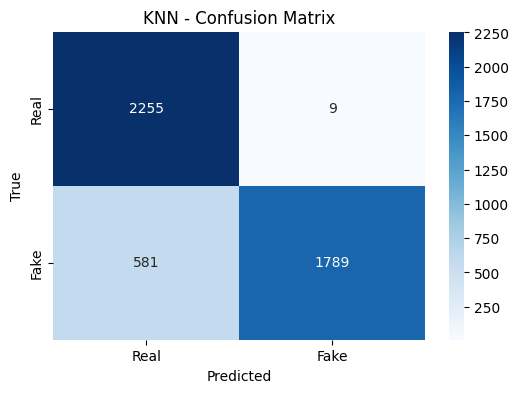

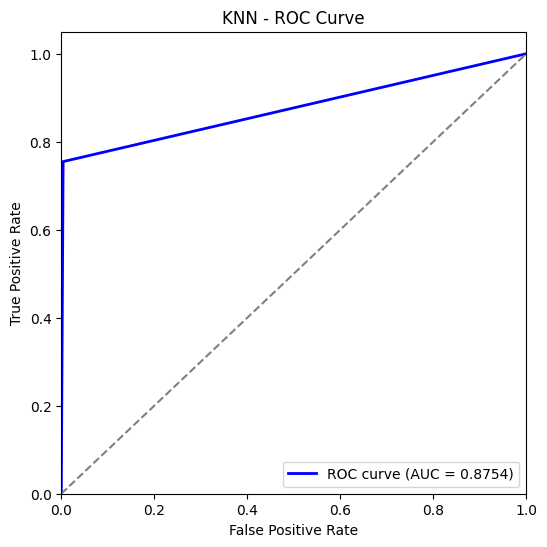

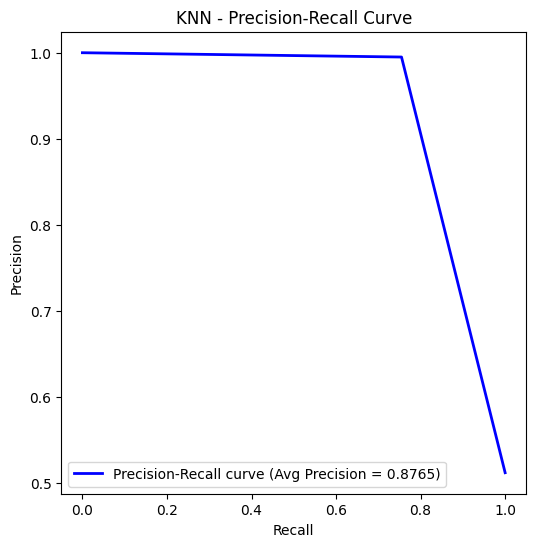

In [66]:
# Evaluate the KNN model on test set
y_test_pred = best_knn_model.predict(X_test_scaled)

evaluate_model(y_test, y_test_pred, "KNN")

# Functions

In [14]:
# Function to print and evaluate performance metrics
def evaluate_model(y_test, y_pred, model_name):
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix Heatmap
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    avg_precision = average_precision_score(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    plt.plot(recall, precision, color='b', lw=2, label=f'Precision-Recall curve (Avg Precision = {avg_precision:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} - Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()